In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
pid = 202
qid = 7963
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())
q.r_count

173377


173416

In [3]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

173377


1508

In [4]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(171869, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,1,For improved exploitation of the energy conten...,Proof of concept for a new energy-positive was...,advanced primary treatment; carbon footprint; ...,"[Engineering, Environmental; Environmental Sci...",0,0
1,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,0,0
2,21,In the endeavour of avoiding presence of biode...,Mechanical-biological treatment: Performance a...,MBT; LCA; Waste composition; Biological treatm...,[Environmental Sciences],0,0
3,23,This paper evaluates the impact of changing we...,Factors Affecting the Frequency and Severity o...,None,"[Engineering, Civil; Transportation; Transport...",0,0
4,46,Glaciers store water over a range of temporal ...,A review of methods for estimating the contrib...,climate change; glacier meltwater; hydrologica...,"[Geography, Physical; Geosciences, Multidiscip...",0,0


In [5]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
            
        for c in Category.objects.filter(project=p):
            if DocCat.objects.filter(doc=d,category=c).exists():
                r[c.name]=1
            else:
                r[c.name]=0
        r_docs.append(r)
    
cat_cols = [c.name for c in Category.objects.filter(project=p)]
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"] + cat_cols]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(1349, 12)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,Indigenous involvement,Community participation,Risk assessment,Policy/proposed measures,Concrete adaptation evaluation,seen
0,75,This article applies a systems engineering app...,Requirements and Functional Analysis of a Mult...,hazard; vulnerability; multi-hazard; disaster ...,[Biodiversity Conservation; Environmental Scie...,1,0,0,0,0,0,1
1,5325,Increasing globalization has promoted the spre...,Historical environmental change in Africa driv...,approximate Bayesian computation; arbovirus; d...,[Biochemistry & Molecular Biology; Ecology; Ev...,0,0,0,0,0,0,1
2,5465,The merits of daily and monthly downscaling mo...,On the choice of the temporal aggregation leve...,None,[Meteorology & Atmospheric Sciences],1,0,0,0,0,0,1
3,9744,Within the commitment of the International Mar...,EEDI analysis of Ro-Pax and passenger ships in...,None,[Transportation],0,0,0,0,0,0,1
4,11017,India is considerably vulnerable in the events...,Local perceptions of and responses to climate ...,Climate change; Community perceptions; Vulnera...,[Environmental Sciences; Environmental Studies],1,0,0,0,0,1,1


In [6]:
df = pd.concat([seen_df,unseen_df],sort=True).sample(frac=1).reset_index(drop=True).fillna(0)
y = df['relevant']
df.head()

,Community participation,Concrete adaptation evaluation,Indigenous involvement,Policy/proposed measures,Risk assessment,content,id,relevant,seen,title,wosarticle__de,wosarticle__wc
0,0.0,0.0,0.0,0.0,0.0,Animal species have a restricted period during...,394921,0,0,Large-sized insects show stronger seasonality ...,circular analyses; conservation; fragmentation...,[Evolutionary Biology]
1,0.0,0.0,0.0,0.0,0.0,An investigation of climatic extreme events pr...,653250,0,0,Spatial and temporal trend analysis of tempera...,Kriging method; Mann-Kendall test; Spatial ten...,"[Geosciences, Multidisciplinary]"
2,0.0,0.0,0.0,0.0,0.0,Climate change's impact on the Sabah and Saraw...,533664,0,0,Climate Change Assessment of Water Resources i...,Hydroclimate model; Sabah and Sarawak; Climate...,"[Engineering, Civil; Environmental Sciences; W..."
3,0.0,0.0,0.0,0.0,0.0,Heat demand is a large contributor to greenhou...,701765,0,0,Assessing the climate impact of district heati...,Systems analysis; District heating; Greenhouse...,"[Engineering, Environmental; Environmental Sci..."
4,0.0,0.0,0.0,0.0,0.0,The recent increased variability of Scotland's...,445963,0,0,"Living with uncertainty: climate change, river...",climate change; river flows; water resources; ...,[Environmental Sciences]


In [7]:
duplicateRowsDF = df[df.duplicated(['title','content'])]
print(duplicateRowsDF.shape)

duplicateRowsDF.head()



(13, 12)


,Community participation,Concrete adaptation evaluation,Indigenous involvement,Policy/proposed measures,Risk assessment,content,id,relevant,seen,title,wosarticle__de,wosarticle__wc
53284,0.0,0.0,0.0,0.0,0.0,"For the last five years, climate change has be...",624201,0,0,Climate change and the resilient society: utop...,Resilience; Climate change; Regional adaptatio...,"[Geosciences, Multidisciplinary; Meteorology &..."
96632,0.0,0.0,0.0,0.0,0.0,"In recent years, environmental issues such as ...",797537,0,0,Influence of Heat Collection Plate Structure o...,exhaust heat; heat recovery; continuous castin...,[Metallurgy & Metallurgical Engineering]
96797,0.0,0.0,0.0,0.0,0.0,Marine ecosystems are undergoing rapid change ...,484795,0,0,North Atlantic climate variability: The role o...,NAO; Climate variability; Physical oceanograph...,"[Geosciences, Multidisciplinary; Marine & Fres..."
100987,0.0,0.0,0.0,0.0,0.0,Reduction of CO2 emissions from the steelmakin...,688378,0,0,Heat Recovery Process from Packed Bed of Hot S...,energy saving; slag; heat recovery; heat trans...,[Metallurgy & Metallurgical Engineering]
130607,0.0,0.0,0.0,0.0,0.0,Global warming has contributed to a greater fr...,520517,0,0,"CLIMATE CHANGE, AGRICULTURAL INSURANCE AND GOV...",climate change; drought; agricultural insuranc...,[Metallurgy & Metallurgical Engineering]


In [8]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
#pred_index = pd.Index(random.sample(list(unseen_index),5000))

k = math.ceil(len(seen_index)*0.8)
train_index = pd.Index(random.sample(list(seen_index),k))

print(seen_index)
print(train_index)

#experiment_index = pd.Index(set(seen_index) | set(pred_index))

test_index = pd.Index([x for x in seen_index if x not in train_index])


Int64Index([   110,    142,    191,    266,    338,    495,    543,    664,
               769,    796,
            ...
            172105, 172215, 172230, 172299, 172302, 172551, 172555, 172765,
            172821, 173044],
           dtype='int64', length=1349)
Int64Index([153849,  78669,  83614,  43497,  92248, 147147,  32018,  95803,
             40280,  82722,
            ...
            146578, 136607, 110692,  62370, 134391,  71041,  89194, 148036,
             33421, 157631],
           dtype='int64', length=1080)


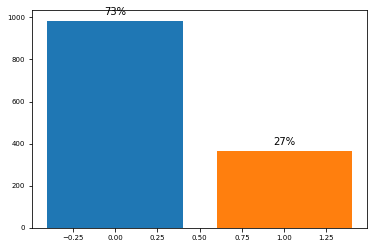

In [9]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [12]:
%%timeit
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=20, max_df=0.6, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
ab_X = vec.fit_transform(df.sample(n=1000)['content'])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words 

21.7 s ± 923 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords as sw
punct = set(string.punctuation)

wnl = WordNetLemmatizer()
stopwords = set(sw.words('english'))
from nltk.corpus import wordnet as wn

def lemmatize(token, tag, wnl=wnl):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return wnl.lemmatize(token, tag)

def ftokenizer(X):
    for sent in sent_tokenize(X):
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            token = token.lower().strip()
            if token in stopwords:
                continue
            if all(char in punct for char in token):
                continue
            if len(token) < 3:
                continue
            if all(char in string.digits for char in token):
                continue
            lemma = lemmatize(token,tag)
            yield lemma

In [ ]:
%%timeit
vec = TfidfVectorizer(
    ngram_range=(1,1),
    min_df=10, max_df=0.9, 
    #strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    tokenizer=ftokenizer
)

y = df['relevant']
ab_X = vec.fit_transform(df.sample(n=1000)['content'])

In [ ]:
import importlib
importlib.reload(learning_utils)

clf = MultinomialNB(alpha=0.1)
clf.fit(ab_X[train_index],y[train_index])

fig, ax = plt.subplots(figsize=(8,5))
learning_utils.plot_model_accuracy(clf,ab_X[test_index],y[test_index],ax,0.5)

In [ ]:
from sklearn.model_selection import KFold

model = {}
model['p'] = []
model['r'] = []
model['e'] = []
model['i'] = []

kf = KFold(n_splits=5)

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    clf = MultinomialNB(alpha=0.1)
    clf.fit(ab_X[k_train],y[k_train])
    predictions = clf.predict(ab_X[k_test])
    model['e'].append(clf.score(ab_X[k_test],y[k_test]))
    # Precision
    model['p'].append(precision_score(predictions,y[k_test]))
    # Recall
    model['r'].append(recall_score(predictions,y[k_test]))
    #print(k_train)
    

In [ ]:
fig, ax = plt.subplots()
ax.plot(model['p'],label="Precision")
ax.plot(model['r'],label="Recall")
ax.plot(model['e'],label="Mean Accuracy")

plt.legend()

plt.show()

In [ ]:
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

In [ ]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    for i,s in enumerate(['p','r','e']):
        y = model[s]
        x = np.random.normal(i+1, 0.04, size=len(y))
        ax.plot(x, y, 'r.', alpha=0.2)
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [33]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

#clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [34]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

406
54431


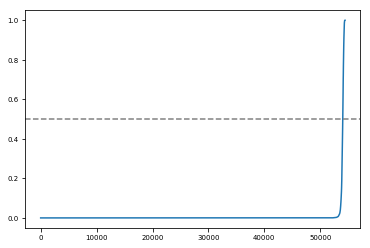

In [39]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

In [40]:
q = Query.objects.get(pk=qid)
q.users.all()

<QuerySet []>

In [41]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

t1 = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
t1.save()

t2 = Tag(
    title="predicted relevant sample_2 {}".format(now),
    query=q
)
#t2.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5:
            print(docs_added)

    
t1.update_tag()
#t2.update_tag()

353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


NameError: name 'd' is not defined

In [26]:
df.to_csv(f'doctables/predictions_{now}.csv',index=False)